## Race Predictions ##
### An exploration of data forcasting techniques so I don't forgot how data works in python ###

In [13]:
import requests
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

#### Load Data ####

For the data, I will be using the  'jolpi.ca F1 API' which can be found [here](https://api.jolpi.ca/ergast/).

At first I played around with the idea of loading and structuing all the data myself, although this was far less performant and would require the split into testing and training data manually,
So instead I will be using Pandas.

For now, I have each race in a seperate DF but later I will combine them into a single dataframe with a race ID column for actual modelling. But this looks nicer for data visualisation for now

----
##### New parameters #####
Since we will also be implementing hyoerparameter tuning, for now I will just add as many parameters from the API as I can for each specific race. This will included as much data as available from qualifying, practices and sprints where applicable. In the future I would also love to get additional information from other sources like which teams/cars have had upgrades made since this can impact the weekend performance, but this is likely to be far in the future as it will take a great deal more work. I expect this will only be possible using something like headline scanning on new sources or another API I haven't found / don't have access too. Alteratively I can just add these manually if I am just working on a single season and built it up incrementally, but this is a lot of manual interaction and has lots of potential for me to miss data ... not that using a news headline parser would be any more accurate ;)

Additionally, since there is only so much information we can gather about the driver performance, it is also important to consider external factors of the races and how these could impact performance in the model. For example, we can look at environmental conditions of secific races and how they can impact specific driver or constructor peformance, or how the time between races correlates to the amount of changes and preperation that can be made by teams and drivers. Envirnonmental impacts themselves is an interesting addition, because to use this in the prediction of the future race data, we will be relying on forecasted data that could turn out to be incorrect, which is important to consider.

Finally, I think it is worth considering experience over multiple seasons, as this has impact on driver performance. While I expect this to hugely increase the training time, its important to consider how more experienced drivers may have previous experience winning races at some circuits and such information can potentionally impact the model accuracy. When this is added, its important to at this stage include information on the recency of the race and which season and constructor each driver was with at this stage, so it looks like all information we are currently gathering can impact this.

In [14]:
# Output data in pandas dataframe
base_url = "http://api.jolpi.ca/ergast/f1/2024/results"
qualifying_url = "https://api.jolpi.ca/ergast/f1/2024/qualifying"
circuits_url = "https://api.jolpi.ca/ergast/f1/circuits/"
limit = 100
offset = 0

response = requests.get(f"{base_url}?limit={1}&offset={offset}").json()
total_results = int(response["MRData"]["total"])
race_dataframes = {}

### Get grid positions
while offset < total_results:
    response = requests.get(f"{base_url}?limit={limit}&offset={offset}").json()
    results = response["MRData"]["RaceTable"]["Races"]

    for race in results:
        race_name = race["raceName"] 
        if race_name not in race_dataframes:
            race_dataframes[race_name] = []
        race_circuit = race["Circuit"]["circuitName"]
        date = race["date"]
        days_since = (datetime.now() - datetime.strptime(date, "%Y-%m-%d")).days
        ### Here we have access to the locatoin of the circuit. use this to get weather information from the certain date
        ### Or get our prediction for the weather

        for res in race["Results"]:
            race_dataframes[race_name].append({
                "Circuit": race_circuit,
                #"DaySinceRace": days_since, # After testing this hugely reduces the model performance. Instead we should consider using information like team upgrades or track characteristics
                "DriverCode": res["Driver"]["code"],
                "ConstructorId": res["Constructor"]["constructorId"],
                "StartingPosition": int(res["grid"]),
                "RaceResult": int(res["position"]),
                "PositionsGained": int(res["grid"]) - int(res["position"]),
            })
    offset += limit

def lap_time_to_ms(lap_time):
    if not lap_time:
        return 0
    minutes, seconds = lap_time.split(":")
    total_ms = int(minutes) * 60 * 1000 + int(float(seconds) * 1000)
    return total_ms

offset = 0
response = requests.get(f"{qualifying_url}?limit={1}&offset={offset}").json()
total_results = int(response["MRData"]["total"])

### Get qualifying times
while offset < total_results:
    response = requests.get(f"{qualifying_url}?limit={limit}&offset={offset}").json()
    results = response["MRData"]["RaceTable"]["Races"]

    for race in results:
        race_name = race["raceName"]
        for entry in race_dataframes[race_name]:
            driver = entry["DriverCode"]

            match = next( (result for result in race["QualifyingResults"] if result["Driver"]["code"] == driver), None )
            if match:
                entry["Q1TimeMS"] = lap_time_to_ms(match.get("Q1"))
                q2_time = lap_time_to_ms(match.get("Q2"))
                entry["Q2TimeMs"] = q2_time
                entry["Q2Progress"] = 1 if q2_time else 0
                q3_time = lap_time_to_ms(match.get("Q3"))
                entry["Q3TimeMs"] = q3_time
                entry["Q3Progress"] = 1 if q3_time else 0
    offset += limit

### Get previous season results

for race_name in race_dataframes:
    race_dataframes[race_name] = pd.DataFrame(race_dataframes[race_name])



print("Results for Bharain:")
print(race_dataframes["Bahrain Grand Prix"])


Results for Bharain:
                          Circuit DriverCode ConstructorId  StartingPosition  \
0   Bahrain International Circuit        VER      red_bull                 1   
1   Bahrain International Circuit        PER      red_bull                 5   
2   Bahrain International Circuit        SAI       ferrari                 4   
3   Bahrain International Circuit        LEC       ferrari                 2   
4   Bahrain International Circuit        RUS      mercedes                 3   
5   Bahrain International Circuit        NOR       mclaren                 7   
6   Bahrain International Circuit        HAM      mercedes                 9   
7   Bahrain International Circuit        PIA       mclaren                 8   
8   Bahrain International Circuit        ALO  aston_martin                 6   
9   Bahrain International Circuit        STR  aston_martin                12   
10  Bahrain International Circuit        ZHO        sauber                17   
11  Bahrain Interna

#### Basic Data Visualisation ####

Just to get a bit of a look at the data before we try some forcasting

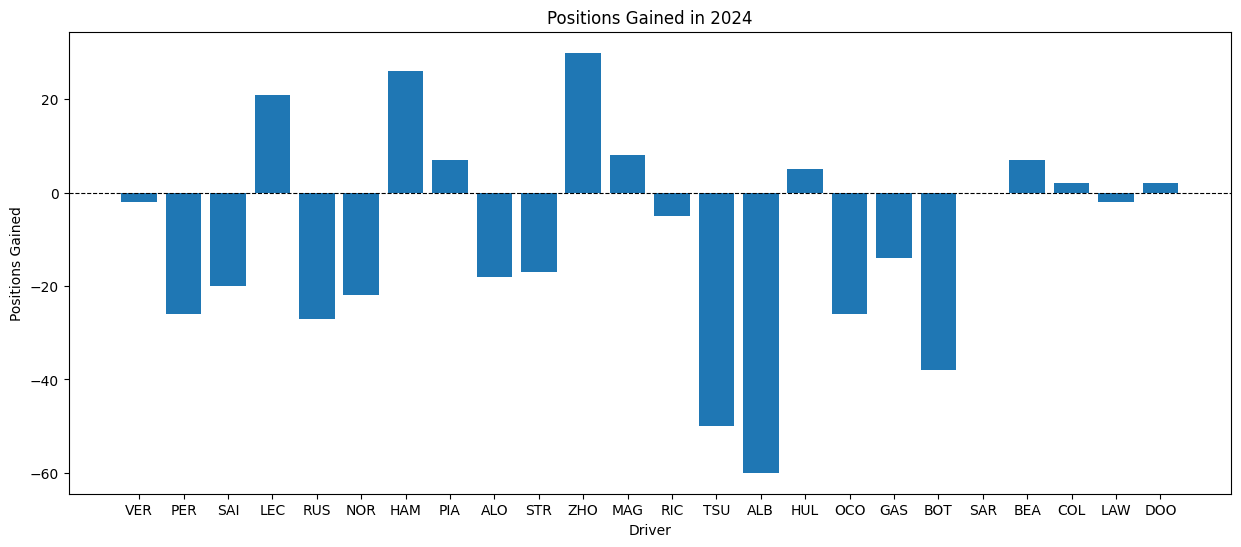

In [15]:
import matplotlib.pyplot as plt

# Total positions gained over the season
# Obviously insanely flawed because it doesn't take into account starting positions and includes anomaly like DNF
position_gained = {}

for race_name, df in race_dataframes.items():
    for _, row in df.iterrows(): 
        driver_code = row["DriverCode"]
        positions_gained = row["PositionsGained"]
        
        if driver_code not in position_gained:
            position_gained[driver_code] = 0
        position_gained[driver_code] += positions_gained

positions_gained_df = pd.DataFrame(list(position_gained.items()), columns=["DriverCode", "PositionsGained"])

plt.figure(figsize=(15, 6))
plt.bar(positions_gained_df['DriverCode'], positions_gained_df['PositionsGained'])
plt.title(f'Positions Gained in 2024')
plt.xlabel('Driver')
plt.ylabel('Positions Gained')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

**Why does this look so negative?**

In terms of starting positions, there is not a number grid position for drivers who start in the pits, and the API returns it as 0. If the driver starts in position 0 then any result, even a 1st place, will be considered a negative result which hugely scew the results.

In order to fix this, we can just manually replace all these 0 values in the starting position with a heuristic calculated starting position. But what if there are multiple starting in the pits? Well there isn't really a way to know, so for now we will just assign this at random.

In [16]:
for race_name, df in race_dataframes.items():
    for index, row in df.iterrows(): 
        starting_pos = row["StartingPosition"]
        if starting_pos == 0:
            df.loc[index, "StartingPosition"] = df["StartingPosition"].max() + 1
    df["PositionsGained"] = df.apply(
        lambda row: int(row["StartingPosition"]) - int(row["RaceResult"]),
        axis=1
    )

print("Results for Bharain:")
print(race_dataframes["Bahrain Grand Prix"])

Results for Bharain:
                          Circuit DriverCode ConstructorId  StartingPosition  \
0   Bahrain International Circuit        VER      red_bull                 1   
1   Bahrain International Circuit        PER      red_bull                 5   
2   Bahrain International Circuit        SAI       ferrari                 4   
3   Bahrain International Circuit        LEC       ferrari                 2   
4   Bahrain International Circuit        RUS      mercedes                 3   
5   Bahrain International Circuit        NOR       mclaren                 7   
6   Bahrain International Circuit        HAM      mercedes                 9   
7   Bahrain International Circuit        PIA       mclaren                 8   
8   Bahrain International Circuit        ALO  aston_martin                 6   
9   Bahrain International Circuit        STR  aston_martin                12   
10  Bahrain International Circuit        ZHO        sauber                17   
11  Bahrain Interna

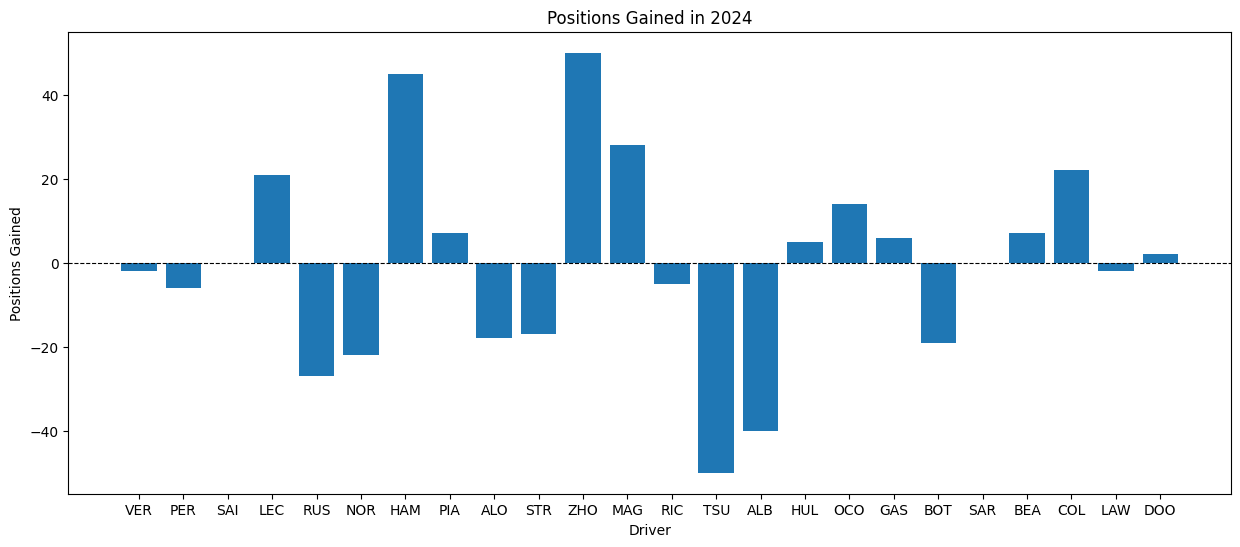

In [17]:
position_gained = {}

for race_name, df in race_dataframes.items():
    for _, row in df.iterrows(): 
        driver_code = row["DriverCode"]
        positions_gained = row["PositionsGained"]
        
        if driver_code not in position_gained:
            position_gained[driver_code] = 0
        position_gained[driver_code] += positions_gained

positions_gained_df = pd.DataFrame(list(position_gained.items()), columns=["DriverCode", "PositionsGained"])

plt.figure(figsize=(15, 6))
plt.bar(positions_gained_df['DriverCode'], positions_gained_df['PositionsGained'])
plt.title(f'Positions Gained in 2024')
plt.xlabel('Driver')
plt.ylabel('Positions Gained')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

In [18]:
## Combine dataframe with a race ID
i = 1
for race_id, race_df in race_dataframes.items():
    race_df['RaceId'] = i  # Add a race identifier to each row
    i += 1

combined_df = pd.concat(race_dataframes.values(), ignore_index=True)
## In the next itteration of this model I will do feature engineering here to include things like constructor and driver average results to help the model
## but this this benchmark I will only use this.


# Convert categorical columns to numeric
le_driver = LabelEncoder()
le_constructor = LabelEncoder()
le_circuit = LabelEncoder()

combined_df['DriverCode'] = le_driver.fit_transform(combined_df['DriverCode'])
combined_df['ConstructorId'] = le_constructor.fit_transform(combined_df['ConstructorId'])
combined_df['Circuit'] = le_circuit.fit_transform(combined_df["Circuit"])

# Split into features and targets
# Remove the positions gained otherwise thats cheating ofc
features = combined_df.drop(['RaceResult', 'PositionsGained'], axis=1)
targets = combined_df['RaceResult']  

print(features.head(5))
print(features.tail(5))

   Circuit  DriverCode  ConstructorId  StartingPosition  Q1TimeMS  Q2TimeMs  \
0        5          22              7                 1     90031     89374   
1        5          14              7                 5     90221     89932   
2        5          18              2                 4     89909     89573   
3        5          10              2                 2     90243     89165   
4        5          17              5                 3     90350     89922   

   Q2Progress  Q3TimeMs  Q3Progress  RaceId  
0           1     89179           1       1  
1           1     89537           1       1  
2           1     89507           1       1  
3           1     89407           1       1  
4           1     89485           1       1  
     Circuit  DriverCode  ConstructorId  StartingPosition  Q1TimeMS  Q2TimeMs  \
474       23          11              3                14     83632     83877   
475       23           9              6                12     83733     83472   
476   

### Test train split ###
Given how important recent performance is on the races, doing the test train split on a race ofrecasting model is different to standard methods.
Again since this is just a V1 baseline of the model, I will use a simple test train split using a cut, but in the future itterations I will experiment with the impact of rolling windows

In [19]:
race_test_split = combined_df["RaceId"].max() - 4

test_split_mask = features["RaceId"] <= race_test_split

features_train = features[test_split_mask]
features_test = features[~test_split_mask]

targets_train = targets[test_split_mask]
targets_test = targets[~test_split_mask]

print(targets_test.tail(5))

474    16
475    17
476    18
477    19
478    20
Name: RaceResult, dtype: int64


##### Model Choices ####

This itteration we intriduce hyperparameter tuning. This will help us pick the optimum parameters for the random forest for use in our model. This is expensive so for now we just use 25 itterations and will explore the impact of this on the model

In [20]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create and evaluate the model
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    score = cross_val_score(classifier, features_train, targets_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

best_params = study.best_params


[I 2025-01-20 21:20:21,449] A new study created in memory with name: no-name-4a42a627-9dc9-4524-b143-b73624abdf57
[I 2025-01-20 21:20:22,569] Trial 0 finished with value: 0.135253164556962 and parameters: {'n_estimators': 435, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.135253164556962.
[I 2025-01-20 21:20:23,101] Trial 1 finished with value: 0.13775316455696202 and parameters: {'n_estimators': 201, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.13775316455696202.
[I 2025-01-20 21:20:23,491] Trial 2 finished with value: 0.16034810126582277 and parameters: {'n_estimators': 150, 'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.16034810126582277.
[I 2025-01-20 21:20:23,871] Trial 3 finished with value: 0.14778481012658226 and parameters: {'n_estimators': 151, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 2 with 

In [21]:

classifier = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
classifier.fit(features_train, targets_train)

RandomForestClassifier(max_depth=11, min_samples_leaf=7, n_estimators=449,
                       random_state=42)

In [22]:
probabilities = classifier.predict_proba(features_test)

from scipy.optimize import linear_sum_assignment
import numpy as np

# Split the probabilities array into 4 equal parts (one for each race)
num_races = 4
drivers_per_race = 20

# Validate that the shape aligns with the expected structure
if probabilities.shape[0] % num_races != 0:
    raise ValueError("The number of rows in probabilities must be divisible by the number of races.")

# Split the array
race_probabilities = np.split(probabilities, num_races)

targets_predict = []

for i, race_probs in enumerate(race_probabilities):
    # For each race, we can then use the probabilities to assign their position.

    # Assume probabilities is a matrix where rows are drivers and columns are positions
    cost_matrix = 1 - race_probs
    _, targets_predict_race = linear_sum_assignment(cost_matrix)
    targets_predict_race = [int(x + 1) for x in targets_predict_race]
    targets_predict.extend(targets_predict_race)
print(list(zip(targets_predict,targets_test)))

[(20, 1), (3, 2), (15, 3), (1, 4), (6, 5), (2, 6), (5, 7), (7, 8), (4, 9), (18, 10), (10, 11), (16, 12), (11, 13), (8, 14), (19, 15), (13, 16), (12, 17), (9, 18), (14, 19), (17, 20), (1, 1), (9, 2), (2, 3), (3, 4), (5, 5), (4, 6), (8, 7), (10, 8), (6, 9), (18, 10), (20, 11), (11, 12), (14, 13), (12, 14), (19, 15), (13, 16), (15, 17), (16, 18), (17, 19), (7, 20), (2, 1), (5, 2), (4, 3), (1, 4), (11, 5), (6, 6), (8, 7), (10, 8), (12, 9), (3, 10), (14, 11), (9, 12), (13, 13), (20, 14), (16, 15), (19, 16), (7, 17), (15, 18), (17, 19), (18, 20), (1, 1), (3, 2), (15, 3), (18, 4), (7, 5), (5, 6), (4, 7), (6, 8), (8, 9), (2, 10), (16, 11), (14, 12), (19, 13), (10, 14), (20, 15), (13, 16), (11, 17), (9, 18), (17, 19), (12, 20)]


Accuracy: 6.25%
              precision    recall  f1-score   support

           1       0.50      0.50      0.50         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4
           5       0.25      0.25      0.25         4
           6       0.25      0.25      0.25         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         4
          13       0.25      0.25      0.25         4
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         4
          17       0.00      0.00      0.00         4
          1

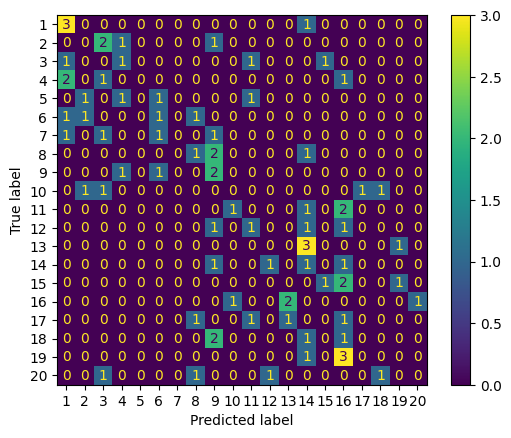

In [23]:


from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

accuracy = accuracy_score(targets_test, targets_predict)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(targets_test, targets_predict))

ConfusionMatrixDisplay.from_estimator(classifier, features_test, targets_test)

#### Results ####

----

##### Model #####

So far just the model has been changed, and we have only evaluated the performance on the very last race. This will be changed after additional parameters are added to the model so we can compare more fairly with the previous model which predicted the results for the last 4 races.

The model actually has a slighly lower average score than the v1 model. This is a mostly negligible amount, but we can attribute this to enforcing a single driver to each position.

#### Average distance from true result ####

In [24]:
import numpy as np
distances = np.abs(targets_test - targets_predict)
average_distance = np.mean(distances)
print(f"Average Distance from True Labels: {average_distance:.2f}")

Average Distance from True Labels: 3.95


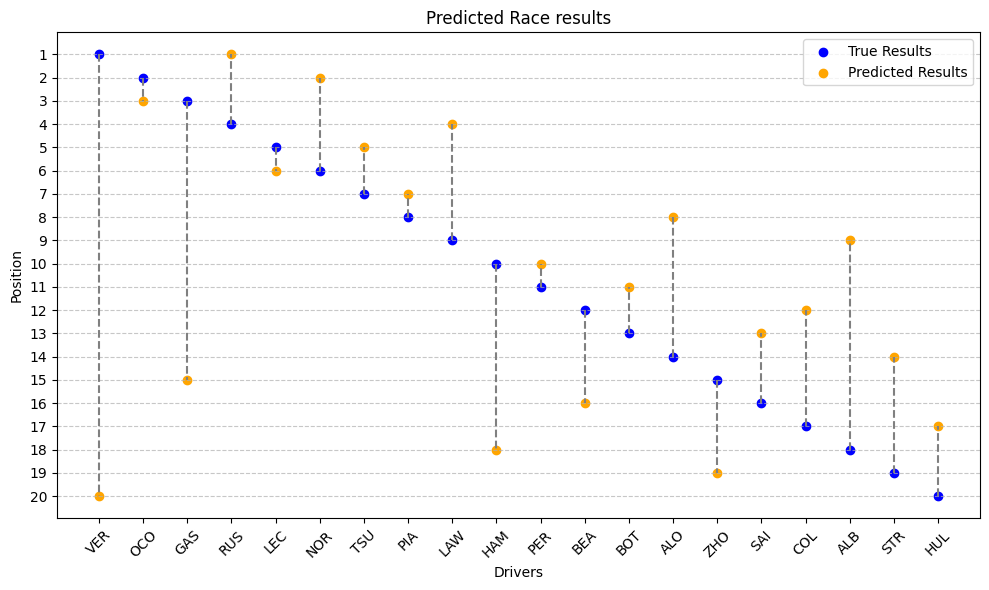

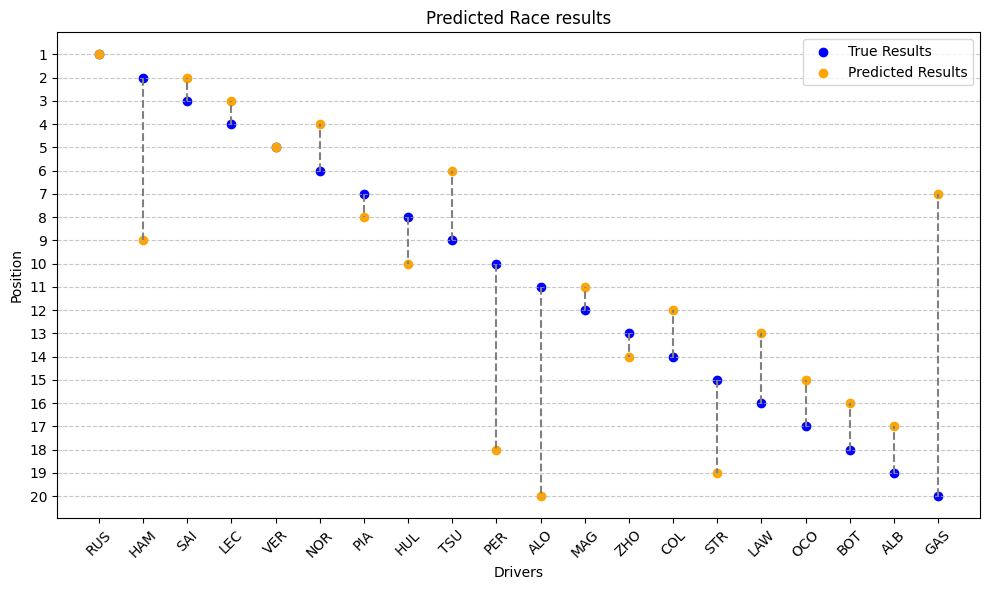

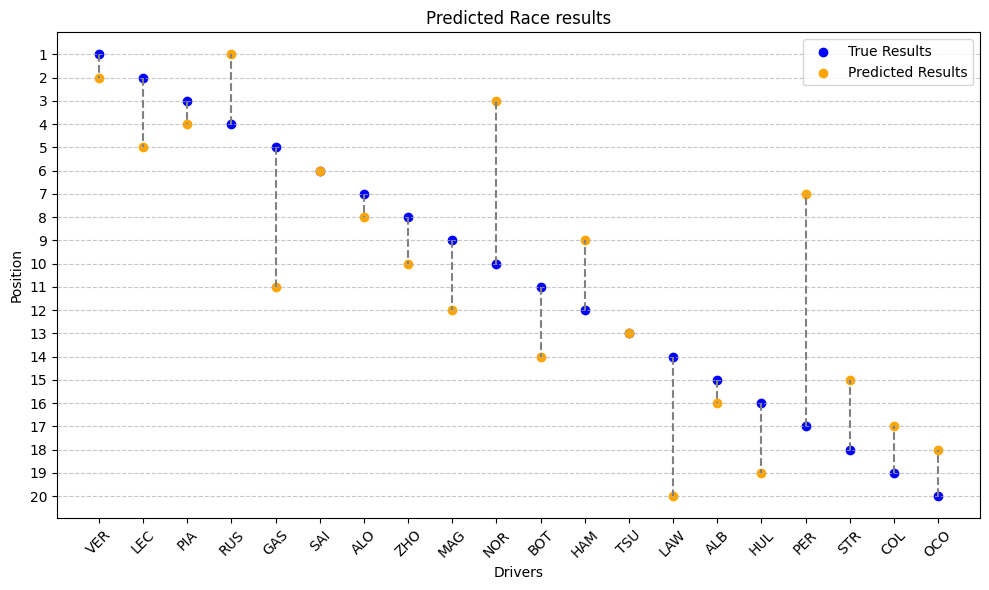

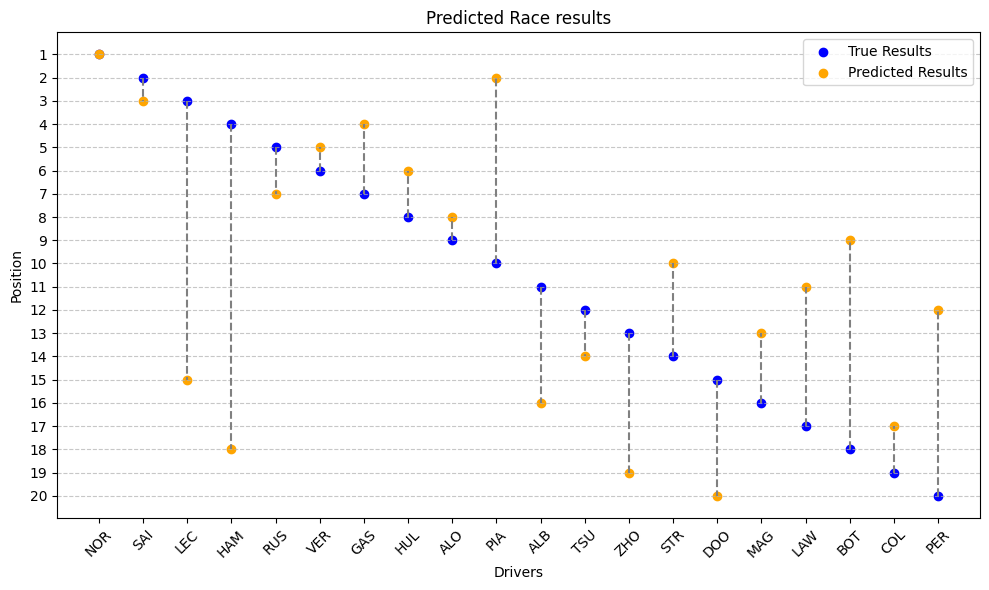

In [25]:
import matplotlib.pyplot as plt

labeled_results = le_driver.inverse_transform(combined_df["DriverCode"])[-80:]
for i in range(4):
    true_results = targets_test[i*20:(i+1)*20]
    driver_labels = labeled_results[i*20:(i+1)*20]
    predicted_results = targets_predict[i*20:(i+1)*20]

    plt.figure(figsize=(10, 6))

    drivers = range(len(true_results))
    plt.scatter(drivers, true_results, label='True Results', color='blue')
    plt.scatter(drivers, predicted_results, label='Predicted Results', color='orange')

    for j in drivers:
        plt.plot([j, j], [true_results.iloc[j], predicted_results[j]], color='gray', linestyle='--')

    plt.xlabel('Drivers')
    plt.ylabel('Position')
    plt.title('Predicted Race results')
    plt.xticks(drivers, driver_labels, rotation=45)
    plt.yticks(np.arange(1, 21, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()


The first thing noticable from this is the issue with the classifier not putting exactly one driver into each position.

Additionally there are some drivers who race very irregularly, and for those we have far less data for the model to use. This is a flaw in the data, and there is nothing we can do about this, since driver turnover is inevitable for a multitude of reasons.

As well as this, the model is black box. We can't see why the model suspects some drivers perform far worse than others. In fact there is very little we will ever be able to do about this. The data is inherintly very dirty and unpredictable, otherwise this activity would be no fun :)

Lets see how we can improve things in v2 